Initialize normal optimization problem

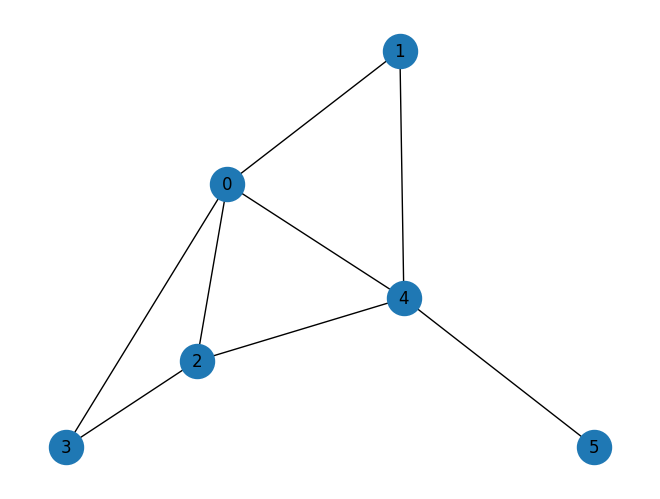

In [26]:
import random
import rustworkx as rx
from rustworkx import is_connected
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np





def make_default_graph(nodes = 4):
    graph = rx.PyGraph()
    graph.add_nodes_from(np.arange(0,nodes,1))
    edge_list = [(0, 1, 1.0), (0, 2, 2.0), (0, 3, 0.5), (1, 2, 1.0), (2, 3, 1.0)]
    """default:
    graph.add_nodes_from(np.arange(0,nodes,1))
    edge_list = [(0, 1, 1.0), (0, 2, 1.0), (0, 4, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0)]"""
    graph.add_edges_from(edge_list)
    return graph

def make_random_graph(nodes = 5):
    default_weight = 1
    graph = rx.PyGraph()
    rng = np.random.default_rng(seed = 173)
    graph.add_nodes_from(np.arange(0,nodes,1))
    edge_list= [(random.randint(0,nodes-1),random.randint(0,nodes-1),1) for _ in range(2*nodes)]
    
    edge_list = [edge for edge in edge_list if (edge[1],edge[0],1.0) not in edge_list] #remove dupes

    
    graph.add_edges_from(edge_list)

    while not is_connected(graph):
        #naive function iteratively adds edges until the graph is connected. can be immensely improved but runs fast enough
        edge = (random.randint(0,nodes-1),random.randint(0,nodes-1),1)
        mirror_edge = (edge[1],edge[0],1.0)

        if edge not in graph.edge_list() and mirror_edge not in graph.edge_list(): #adding, but avoiding dupes
            graph.add_edges_from([(random.randint(0,nodes-1),random.randint(0,nodes-1),1) for _ in range(1)])

    return graph

num_qubits =6 
depth = 3
graph = make_random_graph(num_qubits)


draw_graph(graph, node_size = 600, with_labels = True)

Create a cost function through a hamiltonian from the graph

In [4]:
from qiskit.quantum_info import SparsePauliOp
def build_max_cut_paulis(graph):
    """ 
    Convert graph to pauli list.
    Pauli lists are operation instructions for the quantum circuit, and are 
    strings with mostly I-s and some Z-s. 
    They represent Z-operations on some qubits and I-operations on others.
    """

    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"]*len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0],edge[1])
        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list

max_cut_paulis = build_max_cut_paulis(graph)
cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)

print("Cost function hamiltonian:", cost_hamiltonian)

Cost function hamiltonian: SparsePauliOp(['ZIIZII', 'IIIZIZ', 'ZIIIIZ', 'IIZIIZ', 'ZIIIIZ', 'IZIIIZ', 'IIZIZI', 'IIZZII', 'IIIIZZ', 'ZIZIII', 'ZIIZII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j])


In [5]:
from qiskit.circuit.library import QAOAAnsatz

circuit = QAOAAnsatz(cost_operator = cost_hamiltonian, reps = depth)
circuit.measure_all()

#circuit.draw('mpl')


In [6]:
circuit.parameters



ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(β[2]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1]), ParameterVectorElement(γ[2])])

Optimize the circuit 

In [8]:
from qiskit_ibm_runtime import fake_provider
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

backend = GenericBackendV2(num_qubits=num_qubits)

pm = generate_preset_pass_manager(optimization_level=2,backend=backend)

candidate_circuit = pm.run(circuit)

#candidate_circuit.draw('mpl', fold=False, idle_wires=False)



Execute using qiskit orimitives - what is a qiskit primitive?

In [9]:
initial_gamma = np.pi
initial_beta = np.pi/2 #todo change 
init_params = [(initial_gamma, initial_beta) for _ in range(depth)]

init_params = [number for tup in init_params for number in tup]


In [10]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from scipy.optimize import minimize

objective_func_vals = []

def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    #transform observable defined on virtual qubits to an observable defined on all physical qubits

    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)

    return cost

print(cost_hamiltonian.apply_layout(candidate_circuit.layout))
print(candidate_circuit.layout)

with Session(backend=backend) as session:

    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000

    #error supression - is this necessary? my backend is noiseless - ? 
    #if needed, write in later
    """
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"  

    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations="auto"
"""
    result = minimize(
        cost_func_estimator, 
        init_params,
        args= (candidate_circuit, cost_hamiltonian, estimator),
        method = "COBYLA",
        tol = 1e-2
    )
    print(result)



SparsePauliOp(['IIZIIZ', 'ZIZIII', 'ZIIIIZ', 'ZIIZII', 'ZIIIIZ', 'ZZIIII', 'IIIZZI', 'IIZZII', 'ZIIIZI', 'IIIZIZ', 'IIZIIZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j])
TranspileLayout(initial_layout=Layout({
5: Qubit(QuantumRegister(6, 'q'), 0),
2: Qubit(QuantumRegister(6, 'q'), 3),
3: Qubit(QuantumRegister(6, 'q'), 2),
0: Qubit(QuantumRegister(6, 'q'), 5),
1: Qubit(QuantumRegister(6, 'q'), 1),
4: Qubit(QuantumRegister(6, 'q'), 4)
}), input_qubit_mapping={Qubit(QuantumRegister(6, 'q'), 0): 0, Qubit(QuantumRegister(6, 'q'), 1): 1, Qubit(QuantumRegister(6, 'q'), 2): 2, Qubit(QuantumRegister(6, 'q'), 3): 3, Qubit(QuantumRegister(6, 'q'), 4): 4, Qubit(QuantumRegister(6, 'q'), 5): 5}, final_layout=None, _input_qubit_count=6, _output_qubit_list=[Qubit(QuantumRegister(6, 'q'), 0), Qubit(QuantumRegister(6, 'q'), 1), Qubit(QuantumRegister(6, 'q'), 2), Qubit(QuantumRegister(6, 'q'), 3), Qubit(QuantumRegister(6, 'q'), 4), Qubit

c:\Users\torbjsme\Master\QAOA\myenv\lib\site-packages\qiskit\providers\fake_provider\generic_backend_v2.py:963: RuntimeWarning: Aer not found using BasicSimulator and no noise
  warnings.warn("Aer not found using BasicSimulator and no noise", RuntimeWarning)
c:\Users\torbjsme\Master\QAOA\myenv\lib\site-packages\qiskit\providers\fake_provider\generic_backend_v2.py:963: RuntimeWarning: Aer not found using BasicSimulator and no noise
  warnings.warn("Aer not found using BasicSimulator and no noise", RuntimeWarning)
c:\Users\torbjsme\Master\QAOA\myenv\lib\site-packages\qiskit\providers\fake_provider\generic_backend_v2.py:963: RuntimeWarning: Aer not found using BasicSimulator and no noise
  warnings.warn("Aer not found using BasicSimulator and no noise", RuntimeWarning)
c:\Users\torbjsme\Master\QAOA\myenv\lib\site-packages\qiskit\providers\fake_provider\generic_backend_v2.py:963: RuntimeWarning: Aer not found using BasicSimulator and no noise
  warnings.warn("Aer not found using BasicSimul

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.8641358641358634
       x: [ 3.028e+00  1.906e+00  4.486e+00  1.403e+00  3.081e+00
            2.086e+00]
    nfev: 50
   maxcv: 0.0


c:\Users\torbjsme\Master\QAOA\myenv\lib\site-packages\qiskit\providers\fake_provider\generic_backend_v2.py:963: RuntimeWarning: Aer not found using BasicSimulator and no noise
  warnings.warn("Aer not found using BasicSimulator and no noise", RuntimeWarning)
c:\Users\torbjsme\Master\QAOA\myenv\lib\site-packages\qiskit\providers\fake_provider\generic_backend_v2.py:963: RuntimeWarning: Aer not found using BasicSimulator and no noise
  warnings.warn("Aer not found using BasicSimulator and no noise", RuntimeWarning)


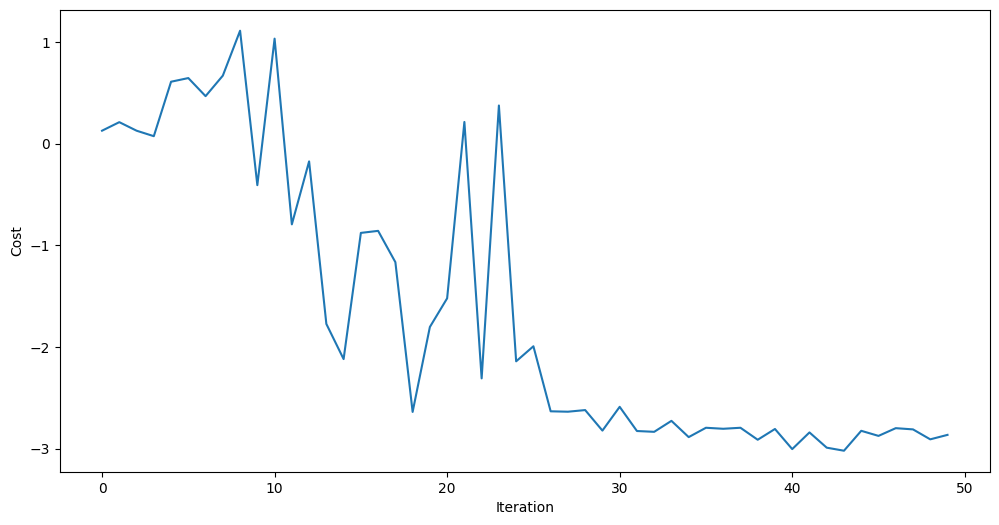

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

In [13]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw('mpl', fold= False, idle_wires=False)

MissingOptionalLibraryError: "The 'pylatexenc' library is required to use 'MatplotlibDrawer'. You can install it with 'pip install pylatexenc'."

In [14]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(mode=backend)
sampler.options.default_shots=10000

pub = (optimized_circuit,)
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
print(counts_int)
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)

{56: 546, 0: 12, 40: 227, 49: 216, 33: 255, 23: 239, 7: 507, 18: 58, 9: 624, 28: 330, 30: 250, 57: 183, 41: 281, 26: 65, 17: 37, 25: 337, 42: 257, 29: 100, 54: 662, 51: 231, 46: 39, 5: 391, 12: 239, 38: 374, 35: 307, 6: 183, 44: 52, 22: 281, 60: 80, 27: 15, 36: 19, 3: 100, 13: 313, 50: 306, 58: 455, 21: 269, 43: 46, 34: 88, 62: 81, 14: 190, 20: 58, 1: 73, 10: 50, 61: 73, 8: 13, 45: 60, 31: 16, 2: 77, 37: 63, 19: 50, 55: 23, 11: 43, 53: 53, 32: 13, 52: 52, 48: 5, 16: 3, 63: 13, 39: 7, 47: 4, 24: 3, 15: 2, 4: 1}
{56: 0.0546, 0: 0.0012, 40: 0.0227, 49: 0.0216, 33: 0.0255, 23: 0.0239, 7: 0.0507, 18: 0.0058, 9: 0.0624, 28: 0.033, 30: 0.025, 57: 0.0183, 41: 0.0281, 26: 0.0065, 17: 0.0037, 25: 0.0337, 42: 0.0257, 29: 0.01, 54: 0.0662, 51: 0.0231, 46: 0.0039, 5: 0.0391, 12: 0.0239, 38: 0.0374, 35: 0.0307, 6: 0.0183, 44: 0.0052, 22: 0.0281, 60: 0.008, 27: 0.0015, 36: 0.0019, 3: 0.01, 13: 0.0313, 50: 0.0306, 58: 0.0455, 21: 0.0269, 43: 0.0046, 34: 0.0088, 62: 0.0081, 14: 0.019, 20: 0.0058, 1: 0.

c:\Users\torbjsme\Master\QAOA\myenv\lib\site-packages\qiskit\providers\fake_provider\generic_backend_v2.py:963: RuntimeWarning: Aer not found using BasicSimulator and no noise
  warnings.warn("Aer not found using BasicSimulator and no noise", RuntimeWarning)


In [15]:
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())

most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(graph))
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [0, 1, 1, 0, 1, 1]


C:\Users\torbjsme\AppData\Local\Temp\ipykernel_14092\2624617538.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.get_children()[int(p)].set_color("tab:purple")


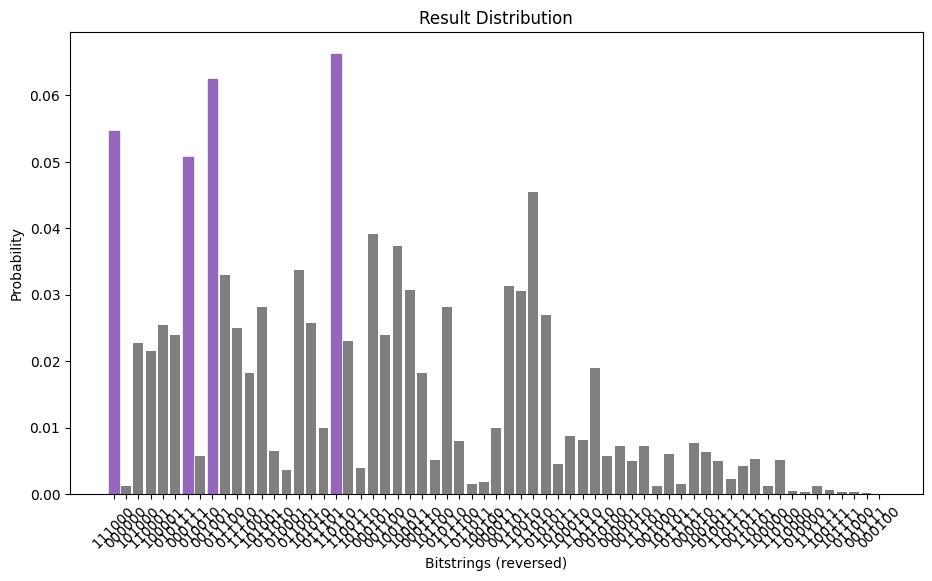

In [16]:
import matplotlib

matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p)].set_color("tab:purple")
plt.show()

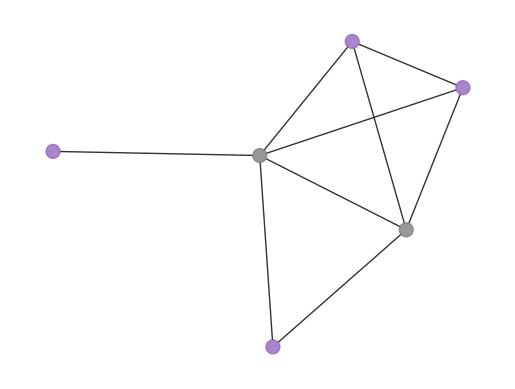

In [17]:
# auxiliary function to plot graphs
def plot_result(G, x):
    colors = ["tab:grey" if i == 0 else "tab:purple" for i in x]
    pos, default_axes = rx.spring_layout(G), plt.axes(frameon=True)
    rx.visualization.mpl_draw(G, node_color=colors, node_size=100, alpha=0.8, pos=pos)


plot_result(graph, most_likely_bitstring)

In [18]:
from typing import Sequence
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(list(graph.nodes())), "The length of x must coincide with the number of nodes in the graph."
    return sum(x[u] * (1 - x[v]) + x[v] * (1 - x[u]) for u, v in list(graph.edge_list()))


cut_value= evaluate_sample(most_likely_bitstring, graph)
print('The value of the cut is:', cut_value)

The value of the cut is: 8


CPLEX implementation of the same problem

-2x_0*x_1-2x_0*x_2-2x_0*x_3-2x_0*x_4-2x_0*x_5-2x_1*x_3-2x_2*x_3-2x_2*x_5-2x_3*x_5+5x_0+2x_1+3x_2+4x_3+x_4+3x_5
solution for: MaxCut
objective: 7
status: OPTIMAL_SOLUTION(2)
x_0 = 1
x_3 = 1
Result bitstring quantum: [0, 1, 1, 0, 1, 1]
       Result classical:  [1, 0, 0, 1, 0, 0]
Same solution True


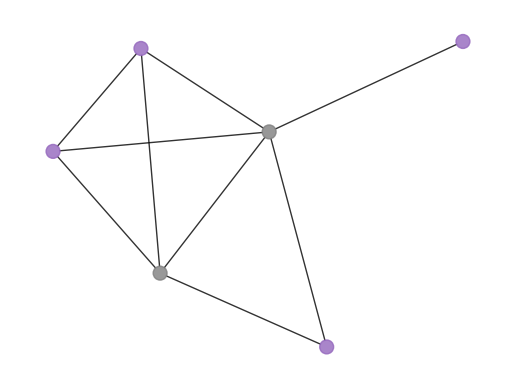

In [ ]:
import cplex
from docplex.mp.model import Model
from rustworkx import NoEdgeBetweenNodes


mdl = Model(name="MaxCut")

variables = mdl.binary_var_list(len(graph), name='x')


objective = 0

for i,var in enumerate(variables):
    for j,var2 in enumerate(variables):
        if i != j and i> j:  
            try:
                graph.get_edge_data(i,j)
                objective += var + var2 - 2*var*var2
            except NoEdgeBetweenNodes:
                pass

print(objective)
mdl.maximize(objective)

solution = mdl.solve()


solution.display()

print("Result bitstring quantum:", most_likely_bitstring)

bitstring = [int(var.solution_value) for var in variables]
print("Result classical: ", bitstring)
    
bools = [a==b for a,b in zip(bitstring,most_likely_bitstring)]
bools_reversed =[a!=b for a,b in zip(bitstring,most_likely_bitstring)]
plot_result(graph, most_likely_bitstring)
    
print("Same solution", all(bools) or all(bools_reversed)) #same cut but different partitions
